## Outliers analysis

### Criterios
- Percentiles: Revisar valores por debajo del P5 o por encima del P95
- Cuartiles:  valores < (Q1 - 1.5 * IQR) o valores > (Q3 + 1.5 * IQR)
- Desviación Absoluta Mediana (MAD): MAD mide la dispersión de los datos en relación con la mediana. Valores altos de MAD pueden indicar la presencia de outliers

- Dentro de la librería **PyOD** (Python Outlier Detection) está el algotirmo **COPOD** (Completely Outlier Detection based on the P-value of the Mahalanobis distance) que se puede usar para detectar outliers. Usar COPOD(contamination=0.05), para crear una instancia del modelo COPOD con un parámetro de contaminación del 0.05 y que el modelo identifique el 5% de los datos como outliers

#### Functions

In [ ]:
def drop_ol(df, contamination, ol_columns):
    '''
    Drop outliers from the whole datset.
        Parameters:
            df (DataFrame): Training data set per campaign.
            contamination (float): Fraction of outliers to be dropped.
            ol_columns (list): List of columns to be used as predictors
                in the outlier detecting algorithm.
        Returns:
            df (DataFrame): Clean (without outliers) dataset.
    '''
    # Outliers
    data = df[ol_columns].astype('float')
    data.reset_index(drop=True, inplace=True)
    model = COPOD(contamination=contamination)
    model.fit(data)
    df = df[~df.index.isin(np.where(model.predict(data)==1)[0])]
    return df.reset_index(drop=True)


def drop_ol_campaigns(df_raw, contamination, ol_columns):
    '''
    Drop outliers from each campaign.
        Parameters:
            df_raw (DataFrame): Table with campaign's historical data.
            contamination (float): Expected fraction of outliers in the dataset.
            ol_columns (list): List with features to look at for ol detection.
        Returns:
            df (DataFrame): Table with campaign's historical data, without outliers.
    '''
    # Drop outliers
    df_list = []
    for campaign in tqdm(df_raw.campaign.unique(), total=df_raw.campaign.nunique()):
        # Filter input
        df = df_raw[df_raw['campaign']==campaign].dropna()
        df.reset_index(drop=True, inplace=True)
        df = drop_ol(df, contamination, ol_columns)
        df_list.append(df.copy())
    df = pd.concat(df_list)
    return df.reset_index(drop=True)


def train_test_per_campaigns(df, train_frac):
    '''
    Crete the train-test datasets for each campaign.
        Parameters:
            df (DataFrame): Table with campaign's historical data.
            train_frac (float): Test fraction for the split.
        Returns:
            df (DataFrame): Table with campaign's historical data labeled
                with the "dataset" column.
    '''
    # Flag train-test
    d_list = []
    #for campaign in tqdm(df.campaign.unique(), total=df.campaign.nunique()):
    for campaign in df['campaign'].unique():
        df_tmp = df[(df['campaign']==campaign)]
        df_tmp.reset_index(drop=True, inplace=True)
        itrain = int(train_frac*df_tmp.shape[0])
        df_train, df_test = df_tmp[:itrain].copy(), df_tmp[itrain+14:].copy()
        df_train['dataset'], df_test['dataset'] = 'train', 'test'
        d_list.append(pd.concat([df_train, df_test]))
    df = pd.concat(d_list)
    return df.reset_index(drop=True)

In [ ]:
contamination = 0.01
train_frac = 0.8
ol_columns = ['budget_USD','cost_USD','nmv_USD','visitors_pur','visits','orders']

### Process data

In [ ]:
 # Campaigns to work with
campaigns = [*df_raw.campaign.unique()]

# Drop outliers
df_nout = drop_ol_campaigns(df_raw, contamination, ol_columns)
df_nout = df_nout[(df_nout.is_cyber==0)]

# Build train-test split
df_nout = train_test_per_campaigns(df_nout, train_frac)

print(df_nout.shape)
df_nout.head()

100%|██████████| 15/15 [00:00<00:00, 56.48it/s]


(7599, 21)


,date,week_day,month_day,year_day,month_year,is_event,is_cyber,previous_cyber_days,campaign,clicks,...,visitors,visitors_pur,visits,orders,total_units_net,budget_USD,cost_USD,nmv_USD,is_week_day,dataset
0,2022-01-17,1,17,17,1,0,0,0,Automotriz,354,...,42,3,44,3,6,236.487526,24.744183,87.221558,1,train
1,2022-01-18,2,18,18,1,0,0,0,Automotriz,1254,...,763,11,840,10,14,236.487526,97.818603,573.849266,1,train
2,2022-01-19,3,19,19,1,0,0,0,Automotriz,4344,...,1032,14,1216,14,32,236.487526,105.129358,1037.573492,1,train
3,2022-01-20,4,20,20,1,0,0,0,Automotriz,7231,...,3120,38,3539,38,53,236.487526,694.305183,2182.033052,1,train
4,2022-01-21,5,21,21,1,0,0,0,Automotriz,34950,...,8004,41,8728,40,77,236.487526,1959.344871,2442.169330,1,train


In [ ]:
## Train/test size by campaign
df_nout.groupby(['campaign', 'dataset']).size().reset_index(name='frequency')

,campaign,dataset,frequency
0,Automotriz,test,101
1,Automotriz,train,458
2,Belleza_Bienestar,test,101
3,Belleza_Bienestar,train,459
4,Climatizacion,test,101
5,Climatizacion,train,458
6,Decoracion_Blanco,test,101
7,Decoracion_Blanco,train,459
8,Dormitorio,test,57
9,Dormitorio,train,284


In [ ]:
count_df_raw = df_raw.groupby('campaign')['campaign'].agg('count')
count_df_nout = df_nout.groupby('campaign')['campaign'].agg('count')
diff = count_df_raw - count_df_nout
diff

campaign
Automotriz                                 23
Belleza_Bienestar                          23
Climatizacion                              23
Decoracion_Blanco                          23
Dormitorio                                 20
Grandes_Electrodomesticos_Cocina           23
Grandes_Electrodomesticos_Lavado           23
Grandes_Electrodomesticos_Refrigeracion    23
Jardineria                                 25
Mascotas                                   24
Menaje                                     24
Muebles                                    20
Muebles_Y_Dormitorio                       17
Pequeños_Electrodomesticos                 23
Telefonia                                  23
Name: campaign, dtype: int64

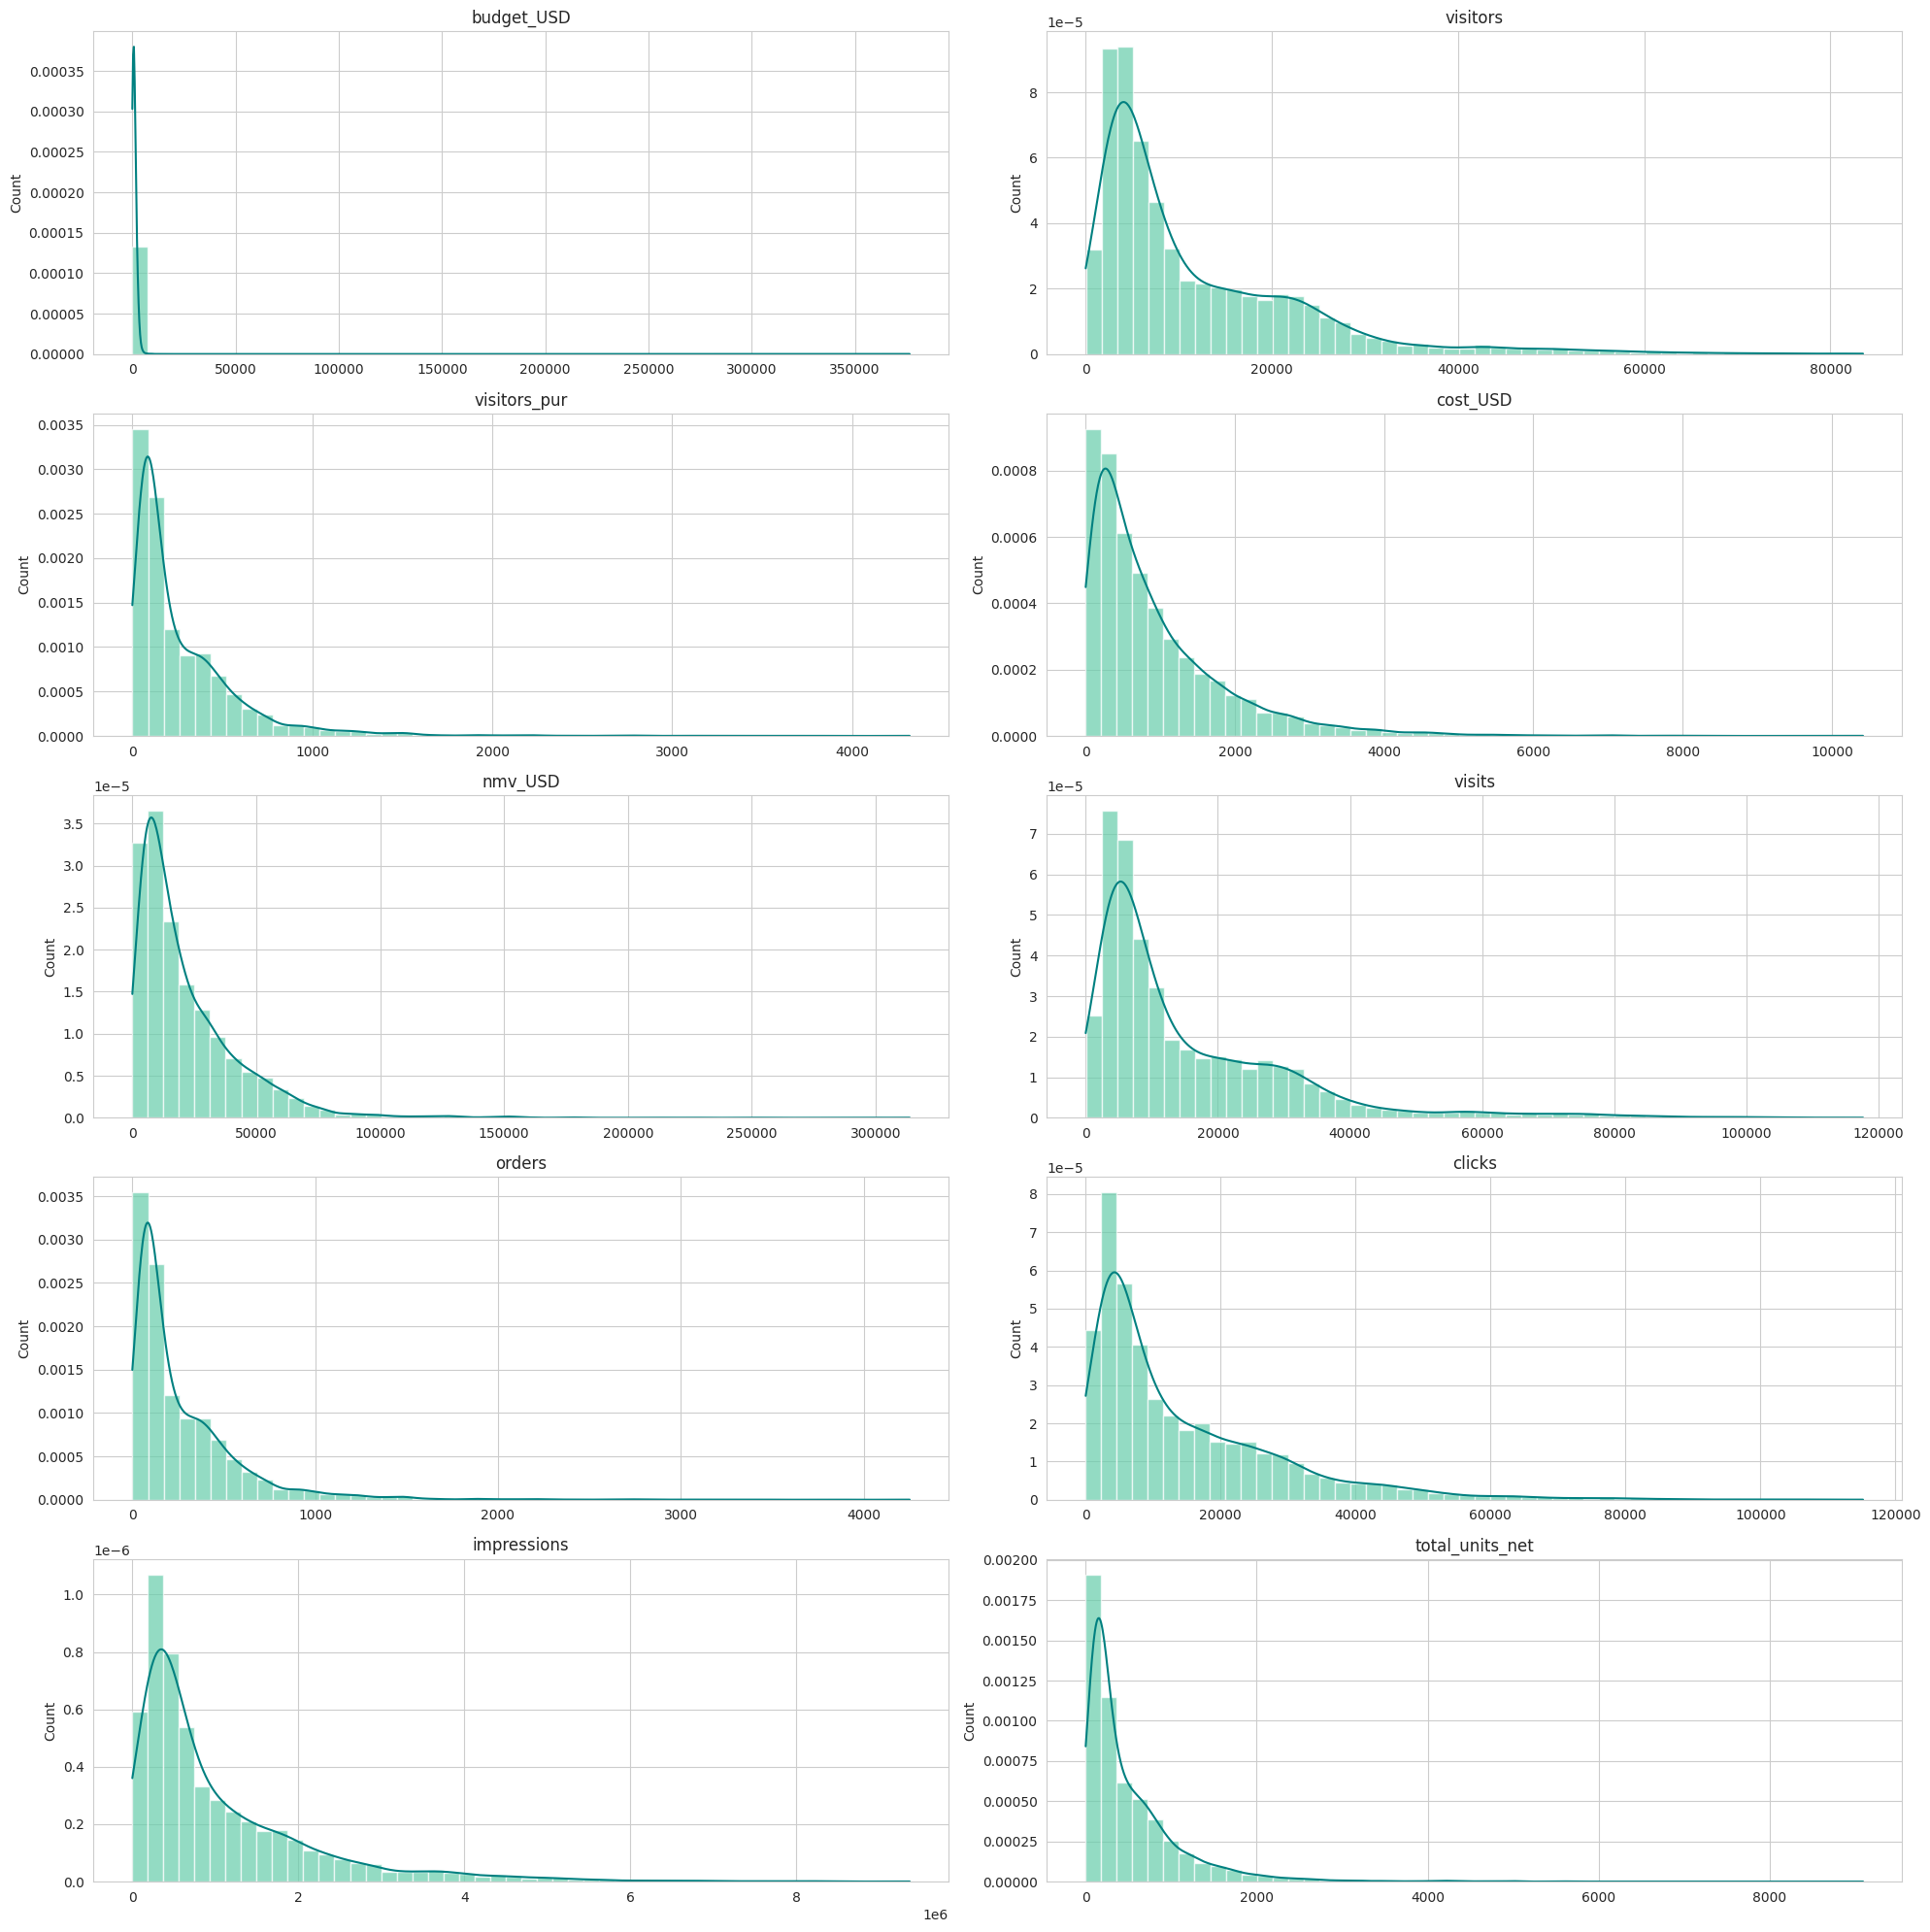

In [ ]:
# Variables to plot
variables = ['budget_USD','cost_USD','nmv_USD','clicks','impressions','visitors','visitors_pur','visits','orders','total_units_net']

cols = 2
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
sns.set_style('whitegrid')

for i, var in enumerate(variables):
    j = i%(rows)
    k = i%(cols)

    df = df_nout[(df_nout.is_cyber==0)]

    axs[j,k].set_title(var)
    # Plot histogram
    _ = axs[j,k].hist(df[var], bins=50, color='mediumaquamarine', alpha=0.7, density=True, label=f'Histogram of {var}')

    # Plot KDE (Kernel Density Estimation) line
    kde = stats.gaussian_kde(df[var].values)
    xx = np.linspace(0, max(df[var]), 1000)
    _ = axs[j,k].plot(xx, kde(xx), label=f'KDE of {var}', color='teal')

    #axs[j,k].set_xlabel(var)
    axs[j,k].set_ylabel('Count')
    axs[j,k].grid(True)
plt.tight_layout()

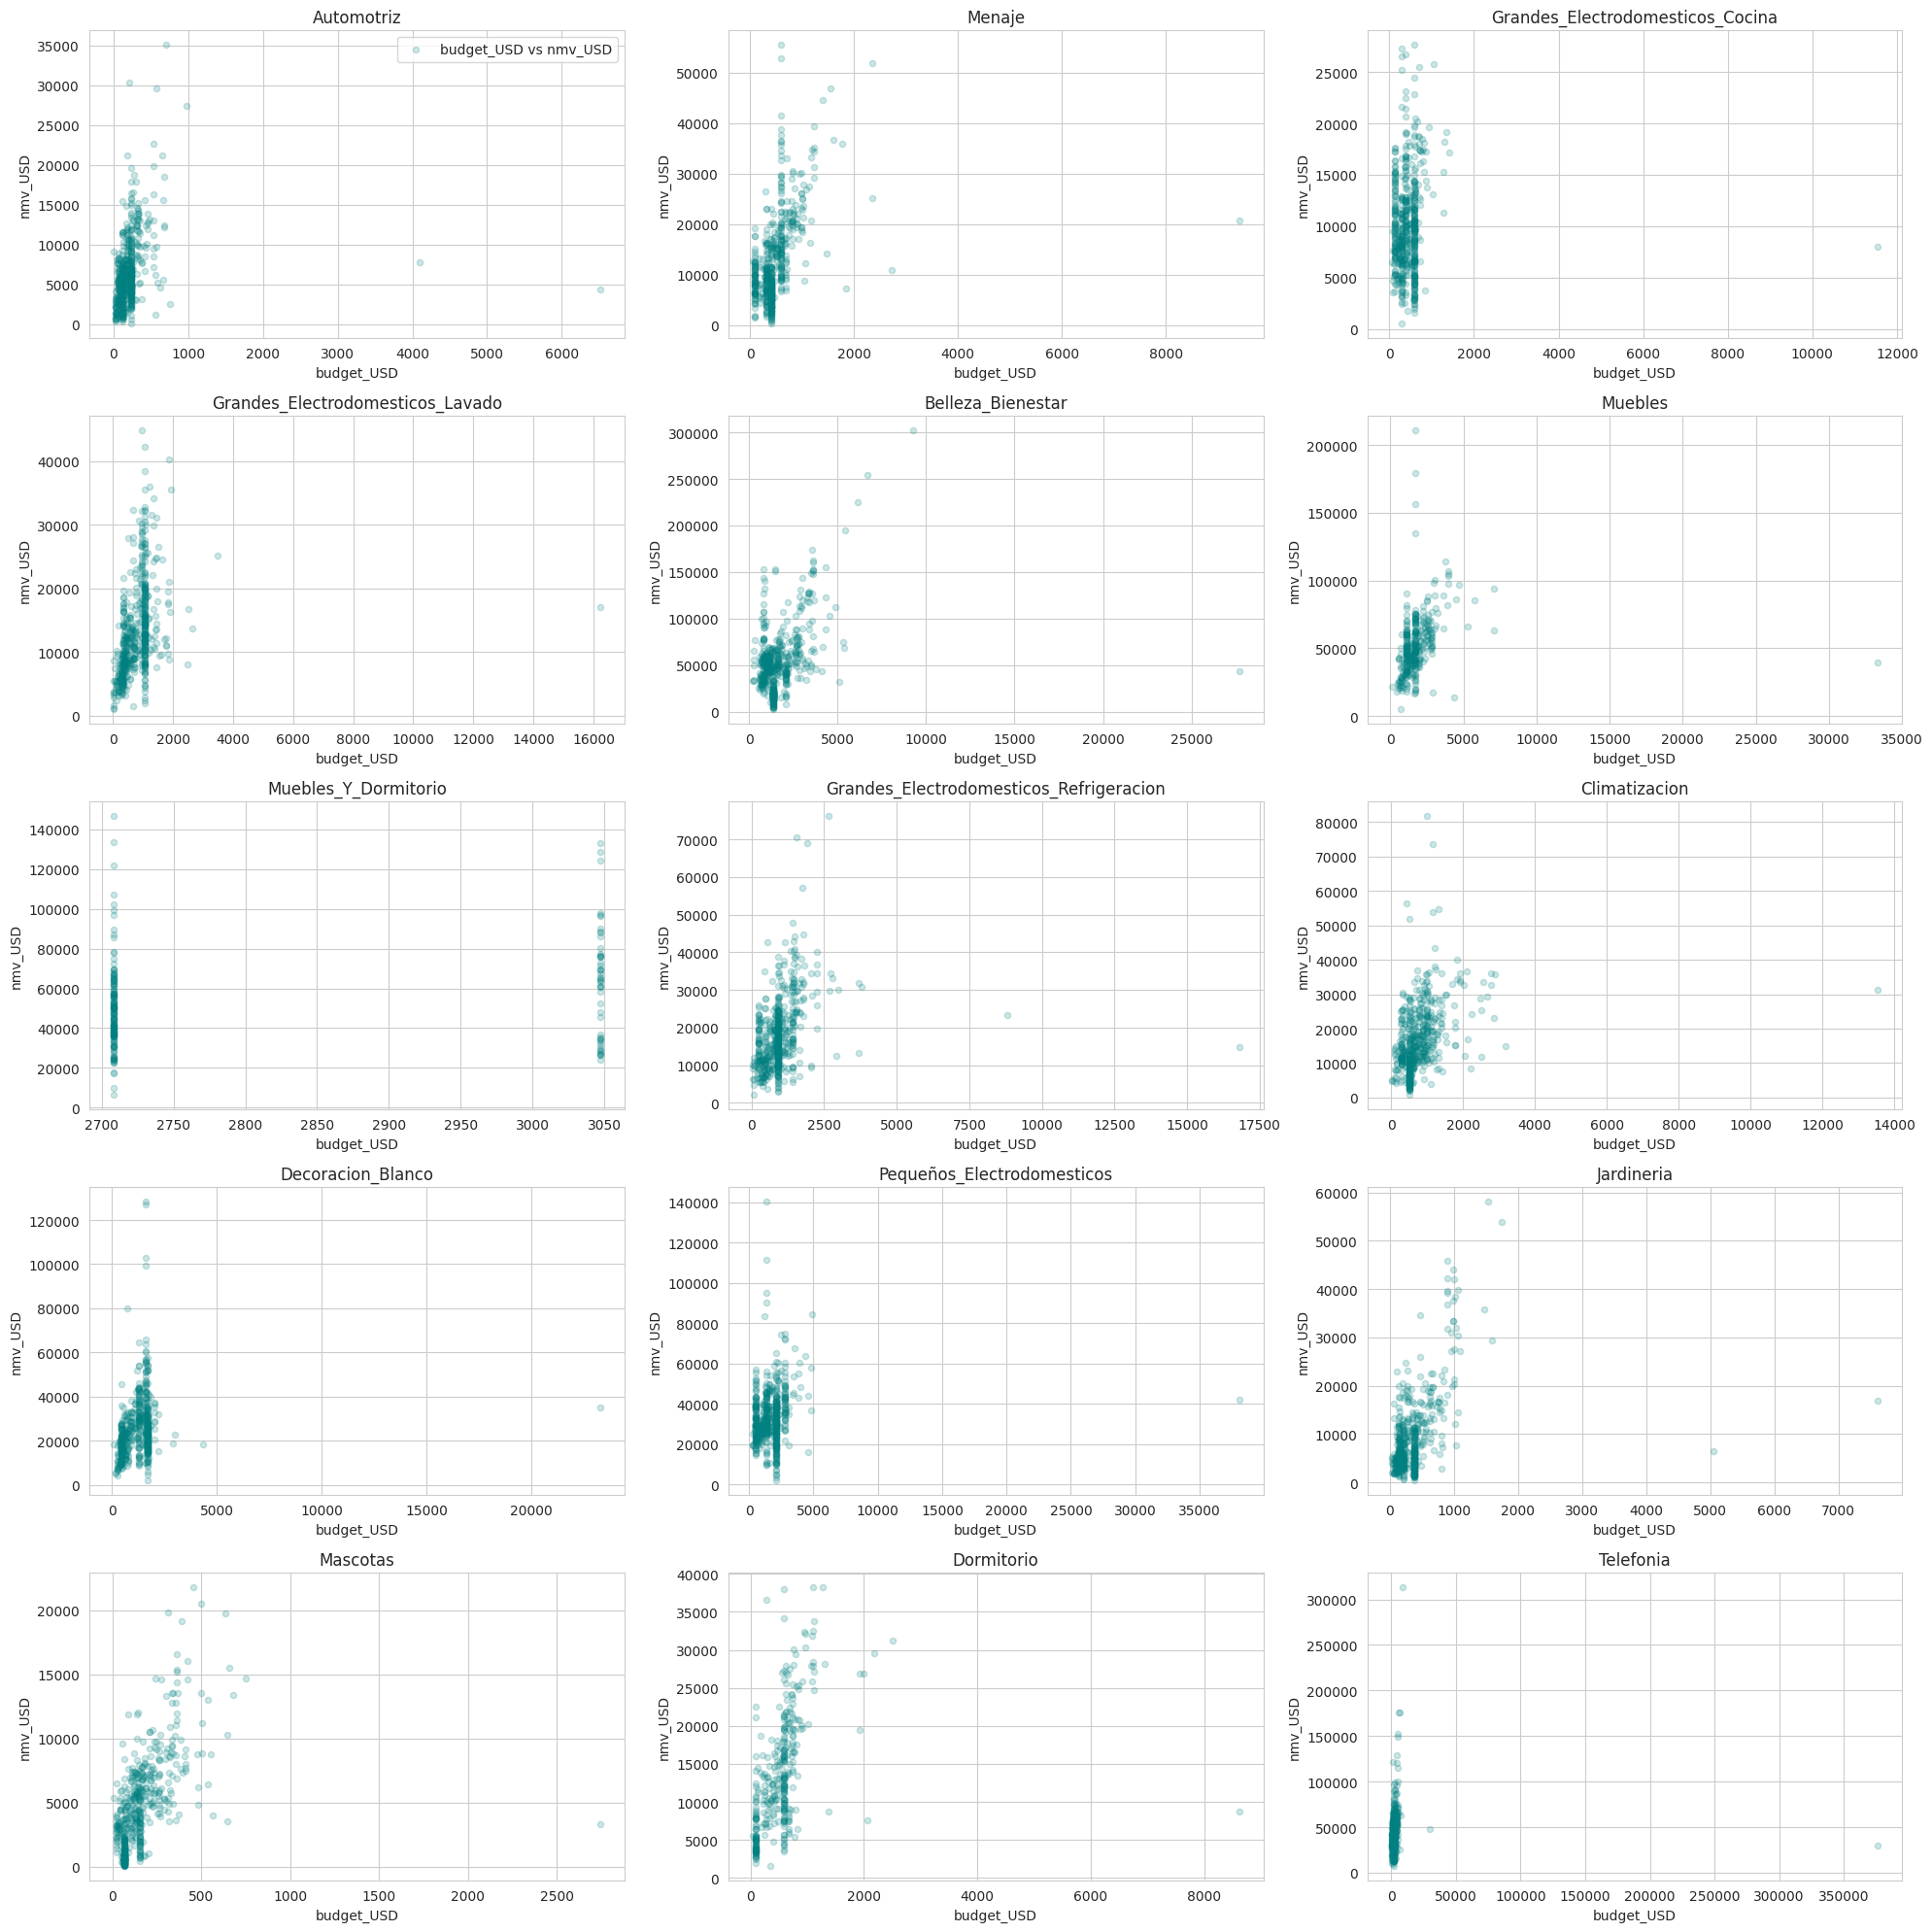

In [ ]:
q = 7
## With cost the graphs look better but budget....
x_ = 'budget_USD' #'cost_USD'
y_ = 'nmv_USD'

cols = 3
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_nout[(df_nout['campaign'] == category) & (df_nout.is_cyber==0)]
    df.dropna(inplace=True)

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(df[x_],df[y_], s=20, color='teal', alpha=0.2, label = f'{x_} vs {y_}')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(df[x_],df[y_], s=20, color='teal', alpha=0.2)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

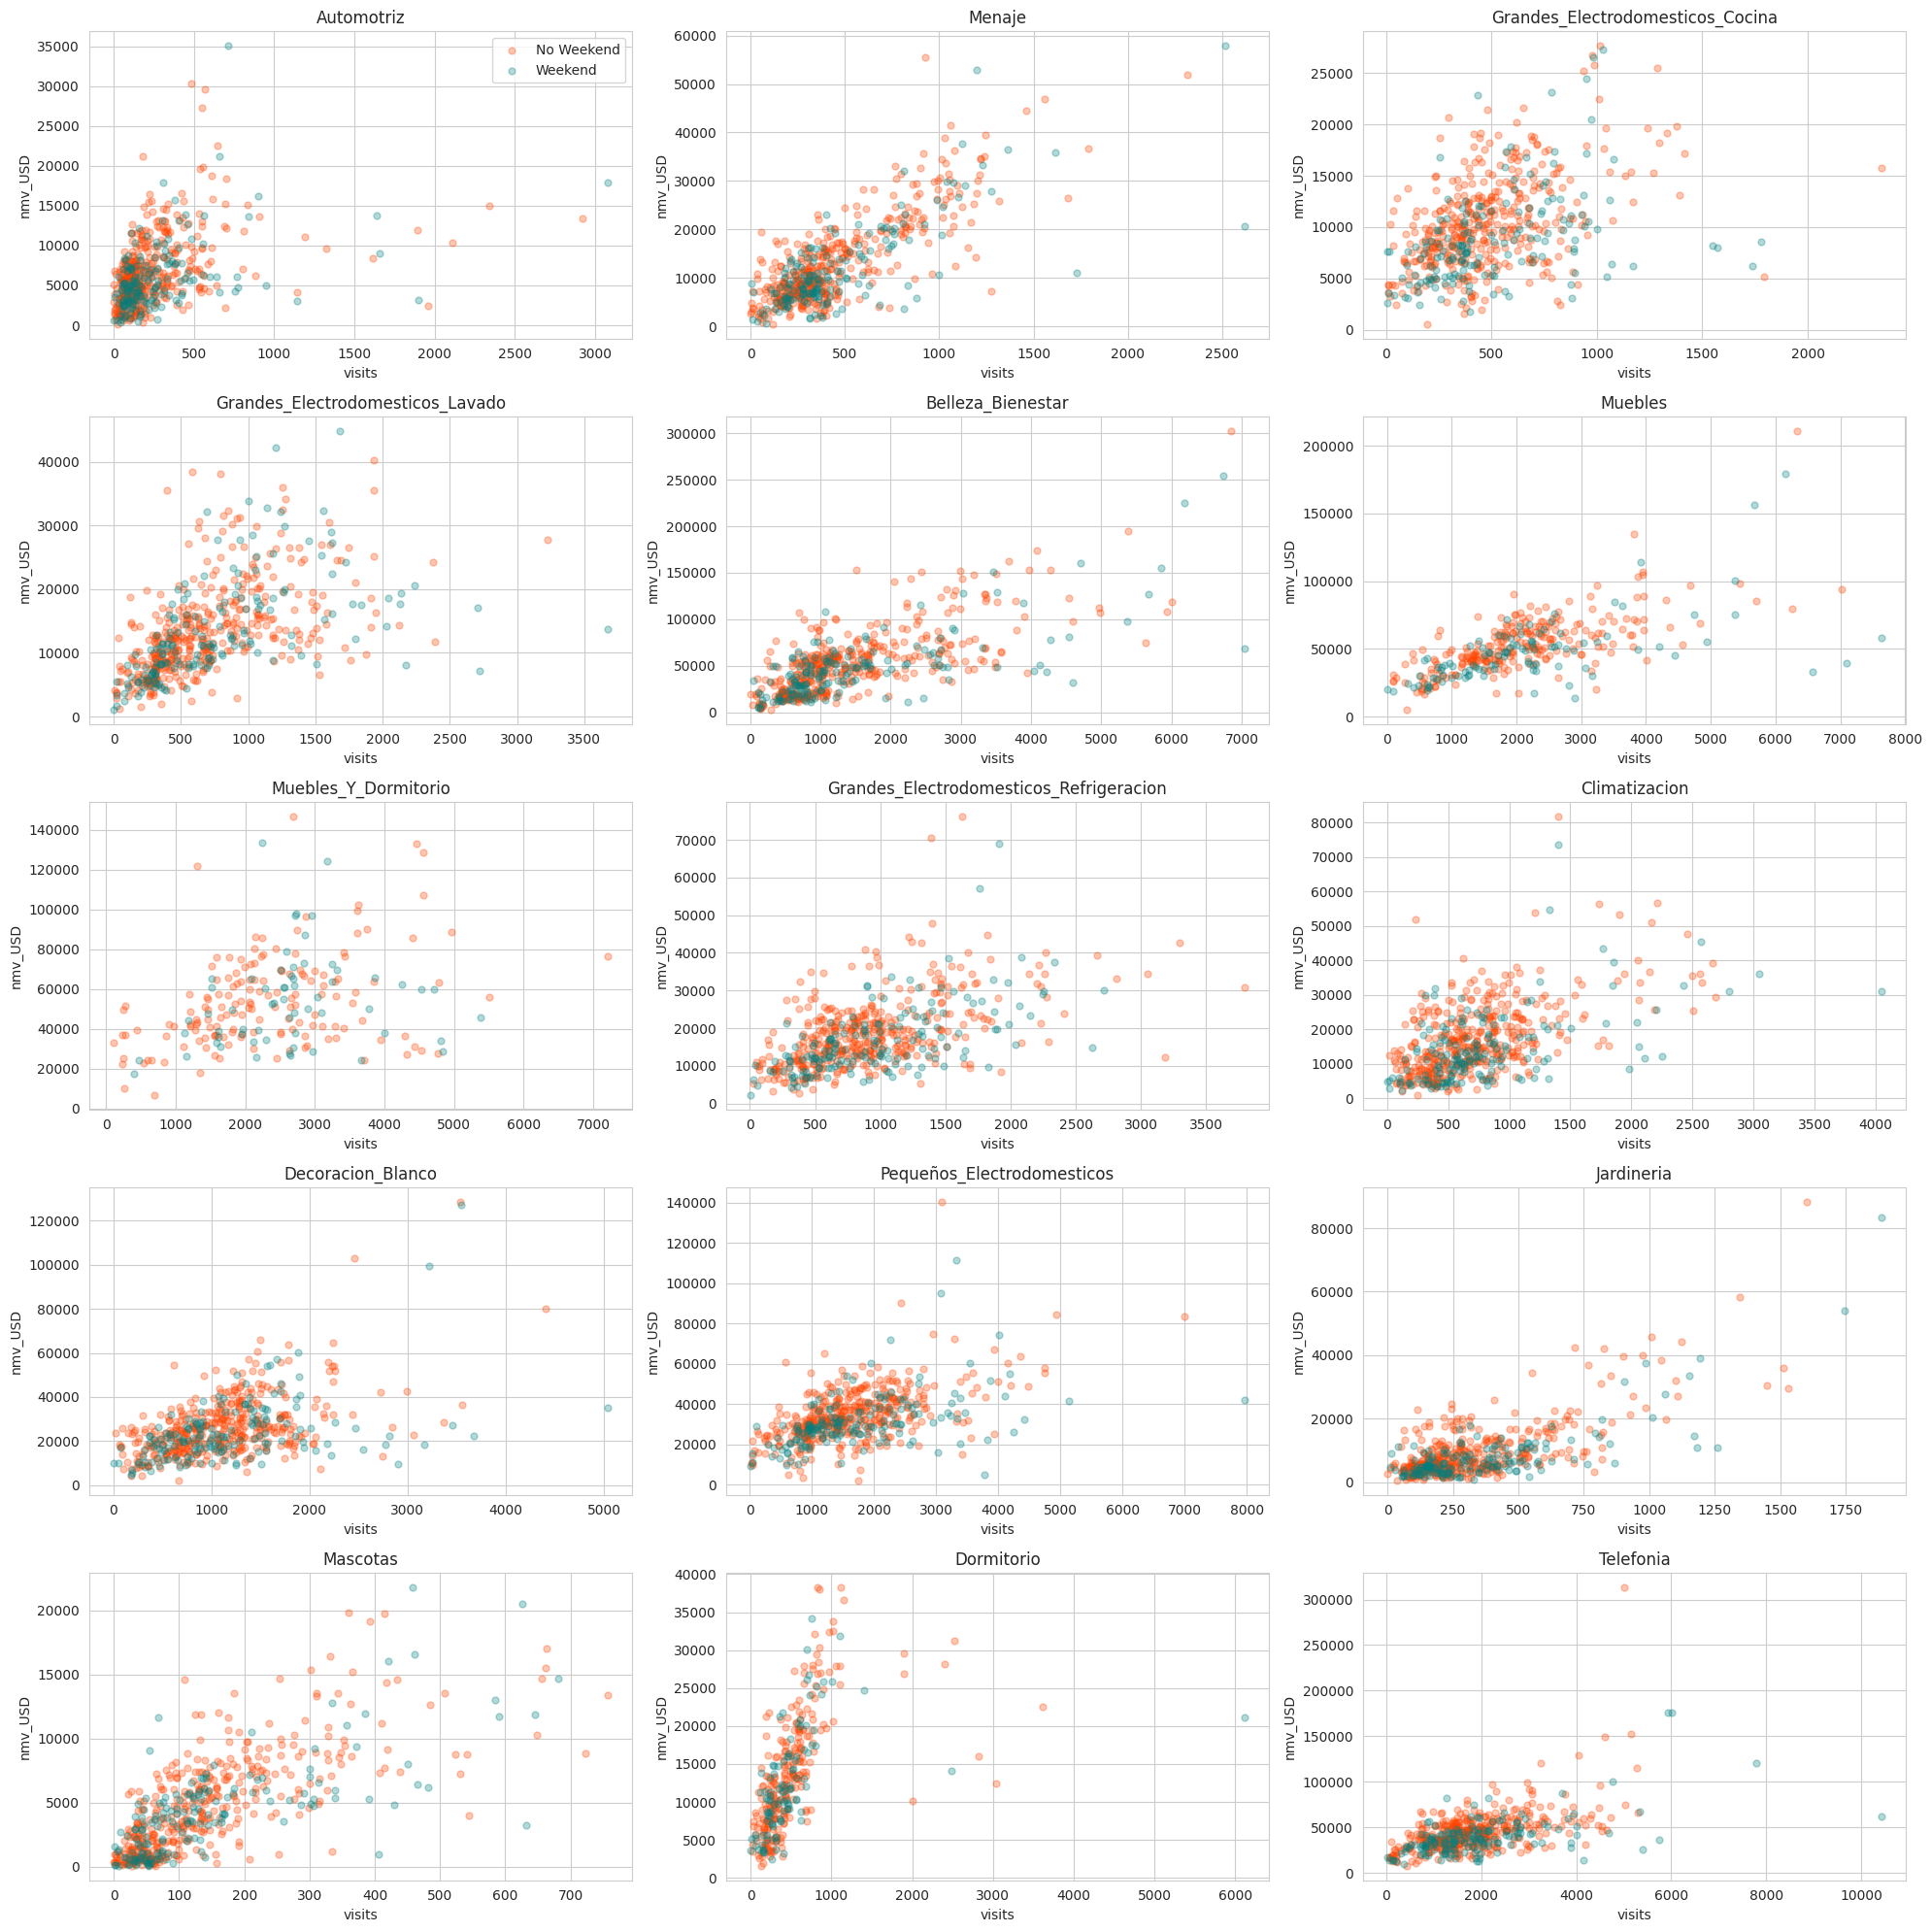

In [ ]:
x_ = 'visits'
y_ = 'nmv_USD'


cols = 3
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign'] == category)] #& (df_raw['cost_USD'] > 0)]
    df.dropna(inplace=True)

    dfe=df[(df.is_week_day==1)&(df.is_cyber==0)]
    dfc=df[df.is_cyber==1]
    dfne=df[(df.is_week_day==0)&(df.is_cyber==0)]
    #df.reset_index(inplace=True)
    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfe[x_label],dfe[y_label], s=25, color='orangered', alpha=0.3, label='No Weekend')
        axs[j,k].scatter(dfne[x_label],dfne[y_label], s=25, color='teal', alpha=0.3, label='Weekend')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfe[x_label],dfe[y_label], s=25, color='orangered', alpha=0.3)
        axs[j,k].scatter(dfne[x_label],dfne[y_label], s=25, color='teal', alpha=0.3)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

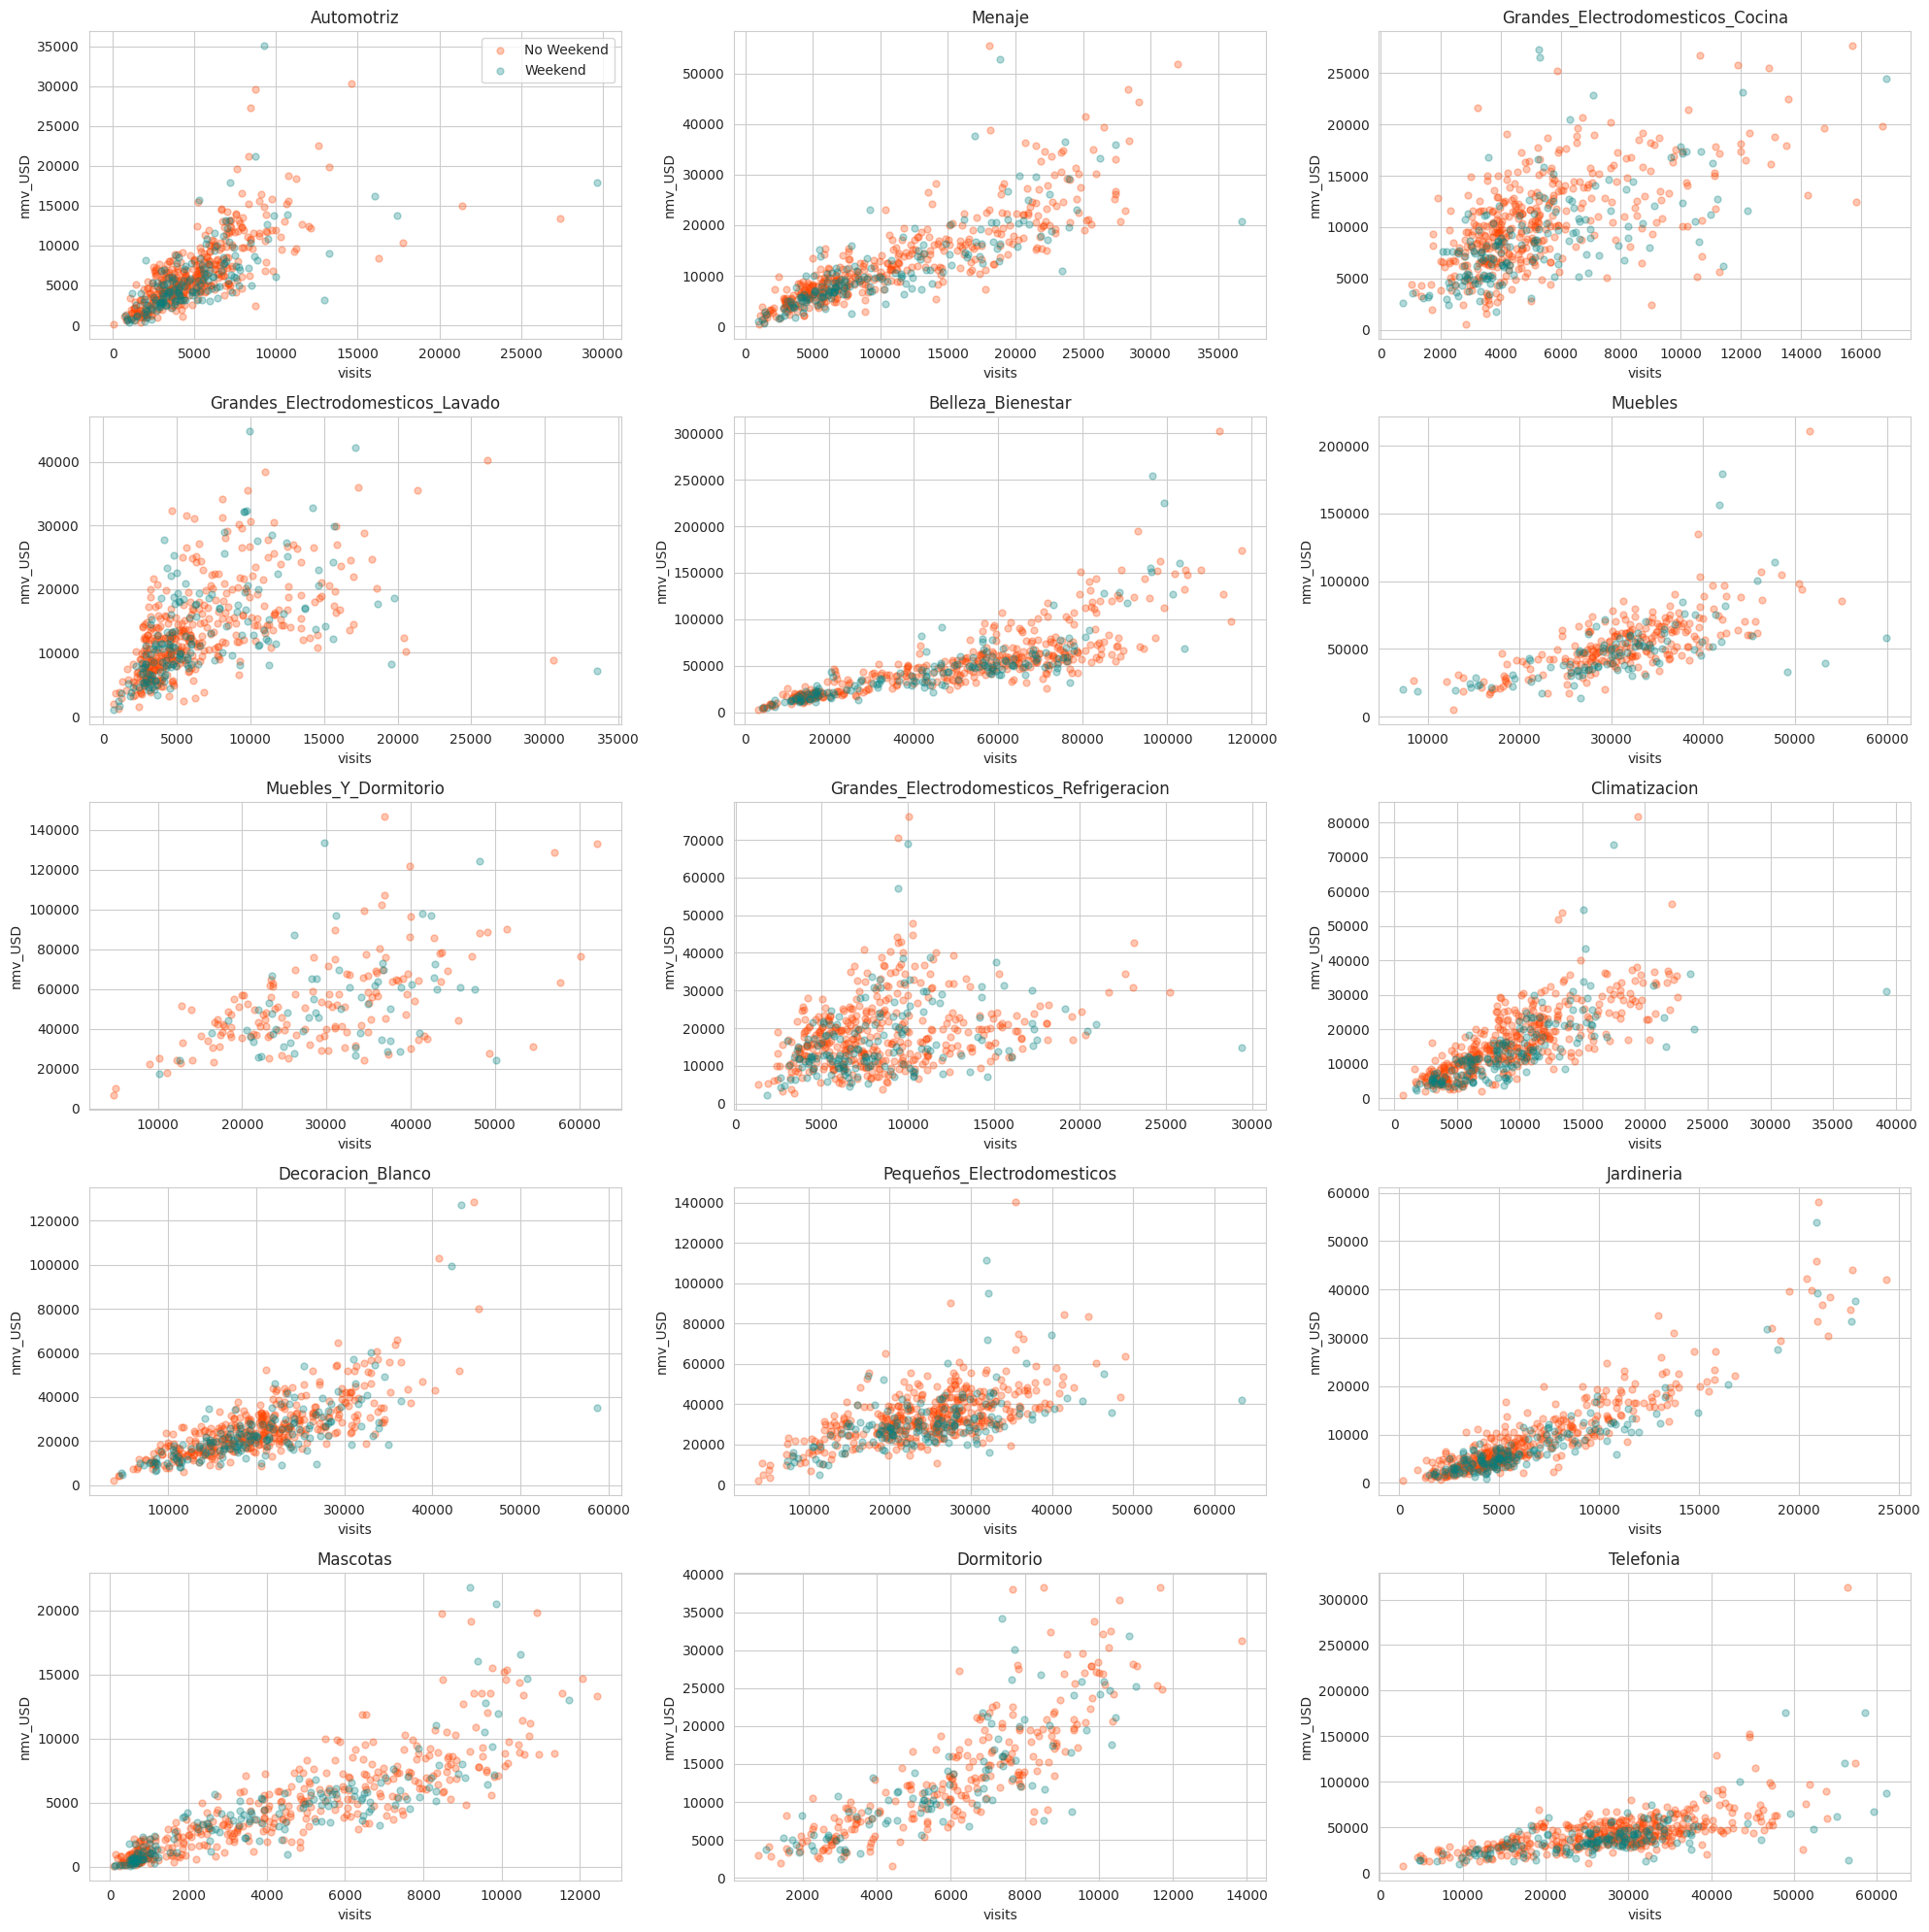

In [ ]:
## Graphs removing outliers and cyber days
x_ = 'visits'
y_ = 'nmv_USD'


cols = 3
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_nout.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_nout[(df_nout['campaign'] == category)]
    df.dropna(inplace=True)

    dfe=df[(df.is_week_day==1)&(df.is_cyber==0)]
    dfne=df[(df.is_week_day==0)&(df.is_cyber==0)]
    #df.reset_index(inplace=True)
    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='orangered', alpha=0.3, label='No Weekend')
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='teal', alpha=0.3, label='Weekend')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfe[x_],dfe[y_], s=25, color='orangered', alpha=0.3)
        axs[j,k].scatter(dfne[x_],dfne[y_], s=25, color='teal', alpha=0.3)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

In [ ]:
 # One-hot Encoder
column = 'campaign'
campaigns = df_nout[column]
df_final = pd.get_dummies(df_nout, prefix=[column], columns = [column], drop_first=False)
df_final[column] = campaigns

print(df_final.shape)
df_final.head()

(7599, 36)


,date,week_day,month_day,year_day,month_year,is_event,is_cyber,previous_cyber_days,clicks,impressions,...,campaign_Grandes_Electrodomesticos_Lavado,campaign_Grandes_Electrodomesticos_Refrigeracion,campaign_Jardineria,campaign_Mascotas,campaign_Menaje,campaign_Muebles,campaign_Muebles_Y_Dormitorio,campaign_Pequeños_Electrodomesticos,campaign_Telefonia,campaign
0,2022-01-17,1,17,17,1,0,0,0,354,39672,...,0,0,0,0,0,0,0,0,0,Automotriz
1,2022-01-18,2,18,18,1,0,0,0,1254,109474,...,0,0,0,0,0,0,0,0,0,Automotriz
2,2022-01-19,3,19,19,1,0,0,0,4344,124152,...,0,0,0,0,0,0,0,0,0,Automotriz
3,2022-01-20,4,20,20,1,0,0,0,7231,413879,...,0,0,0,0,0,0,0,0,0,Automotriz
4,2022-01-21,5,21,21,1,0,0,0,34950,1170805,...,0,0,0,0,0,0,0,0,0,Automotriz


In [ ]:
## Train/test size by campaign
df_final[(df_final.campaign == 'Belleza_Bienestar')|(df_final.campaign == 'Jardineria')|(df_final.campaign == 'Telefonia')].\
groupby(['campaign', 'campaign_Telefonia']).size().reset_index(name='frequency')

,campaign,campaign_Telefonia,frequency
0,Belleza_Bienestar,0,560
1,Jardineria,0,558
2,Telefonia,1,559


### Export final dataframe


1.   Money fields modified to USD
2.   Outliers removed
3.   Cyber days removed
4.   Enconde campaign

### Final clean dataframe name: **df_final**


